In [1]:
import requests
import json
import pandas as pd
import csv
import datetime
import dateutil.parser
import unicodedata
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
#This module provides regular expressions

In [2]:
# Reads dataset file
df = pd.read_csv('Data_Set_Student_Reviews.csv', header = None, encoding='utf-8')

# Changes header title
df.columns=['Text']

df

Text
0    1.                 Before uploading the video ...
1    2.                Before, she is kind to her s...
2    3.                Can be improved. Hope she co...
3    4.                For this subject, some topic...
4                5.                Give more examples.
..                                                 ...
848  846.       The professor was active in google ...
849   847.        Very nice and accommodating teacher!
850  848.       Words  can''t express how i am grat...
851  849.       in my opinion, the instructor''s wa...
852  850.        please speak tagalog when teaching...

[853 rows x 1 columns]

In [3]:
# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = text.lower()
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7F]+',r' ', text) # replace non-ASCII characters
    text = re.sub('\s\s+', ' ', text)  # remove extra whitespace
    return text

# Cleaning the text in the Text column
df['Cleaned_Text'] = df['Text'].apply(clean)
df

Text  \
0    1.                 Before uploading the video ...   
1    2.                Before, she is kind to her s...   
2    3.                Can be improved. Hope she co...   
3    4.                For this subject, some topic...   
4                5.                Give more examples.   
..                                                 ...   
848  846.       The professor was active in google ...   
849   847.        Very nice and accommodating teacher!   
850  848.       Words  can''t express how i am grat...   
851  849.       in my opinion, the instructor''s wa...   
852  850.        please speak tagalog when teaching...   

                                          Cleaned_Text  
0     before uploading the video discussion i sugge...  
1     before she is kind to her students my classma...  
2     can be improved hope she considers personal n...  
3     for this subject some topics are not easy but...  
4                                  give more examples   
..                                                 ...  
848   the professor was active in google meets spec...  
849               very nice and accommodating teacher   
850   words can t express how i am grateful with ou...  
851   in my opinion the instructor s way of encoura...  
852          please speak tagalog when teaching please  

[853 rows x 2 columns]

In [4]:
df.loc[0, 'Cleaned_Text']

' before uploading the video discussion i suggest that she discuss it clearly and remove the errors because it can confuse our course class '

In [5]:
# Sorts Text column
df.sort_values('Text', inplace = True)

# Counts numbers of duplicates
duplicates = df.pivot_table(columns=['Text'], aggfunc='size')
duplicates

Text
-                   She didn''t release our grades from prelims to midterms."                                                                                                                                                                                                                                                                                                                                                                                                             1
-                   Titus 2:7-8"                                                                                                                                                                                                                                                                                                                                                                                                                                                          1
-                   she only reads the modu

In [6]:
#set tagalog stopwords
stop_words_tl = ["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang",
 "apat","at","atin","ating","ay","bababa","bago","bakit","bawat","bilang","dahil",
 "dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa",
 "ginawang","gumawa","gusto","habang","hanggang","hindi","huwag","iba","ibaba",
 "ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas",
 "ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila",
 "kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan",
 "katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat",
 "lamang","likod","lima","maaari","maaaring","maging","mahusay","makita","marami",
 "marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na",
 "nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan",
 "ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano",
 "pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan",
 "panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta",
 "sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad",
 "tungkol","una","walang", "po"]

In [7]:
#convert the list to set to match the type of the english stopwords
stop_words_tl = set(stop_words_tl)

In [8]:
#set english stopwords
import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
stop_words_en=set(stopwords)
print(stop_words_en)

{'haven', 'from', 'below', "wouldn't", "hasn't", 'do', 'am', 'here', 'was', 'out', 'just', 'ma', 'doing', 'my', 'll', "doesn't", 'some', "mightn't", 'this', 'ourselves', 'himself', 'up', 'too', 'or', 'under', 'ours', 'having', 'he', 'further', 'with', 'which', 'on', 'there', 'her', 'its', 'about', 'o', 'can', 'only', "needn't", 'our', 'we', 'own', 'same', 'should', 'because', "wasn't", 'very', "it's", 'yours', 'who', 'wouldn', 'weren', 'they', 'isn', 'any', 'once', "aren't", "won't", 'yourself', 'will', 'be', 'more', 'don', 'but', 'where', 'for', 'shan', 'when', 'is', 'were', 'above', 'd', 'mustn', 'if', 'had', 'an', 'did', 't', 'hasn', 'y', 've', "haven't", 'yourselves', 'and', 'until', 'nor', "should've", 'as', 'of', 'down', 'to', 'at', 'their', 'she', 'hers', 'other', 'between', 'no', 'them', 'what', 'myself', 'i', 'shouldn', "you're", 'themselves', 'after', 'off', 'mightn', 'against', 'now', "you've", 'while', 'that', 'those', 'few', 'wasn', "you'd", 'before', 'then', 'both', 'you'

In [9]:
#removing english and tagalog stopwords
from nltk.tokenize import word_tokenize

def removing_en_stopwords(text):
    tokens = word_tokenize(text)
    text = [word for word in tokens if not word in stop_words_tl if not word in stop_words_en]
    return text
df['removed_stopwords'] = df.Cleaned_Text.apply(lambda x: removing_en_stopwords(x))
df

Text  \
170  -                   She didn''t release our gr...   
49                    -                   Titus 2:7-8"   
311  -                   she only reads the module ...   
0    1.                 Before uploading the video ...   
9    10.             I appreciate the faculty conce...   
..                                                 ...   
95   95.            Activities are timed which is o...   
96   96.           At first, I liked my professor b...   
97   97.            Doesn''t conduct classes, but p...   
98                        98.           Excellent prof   
99   99.           For the duration of this semeste...   

                                          Cleaned_Text  \
170   she didn t release our grades from prelims to...   
49                                              titus    
311   she only reads the module when she is having ...   
0     before uploading the video discussion i sugge...   
9     i appreciate the faculty concerned in this su...   
..                                                 ...   
95    activities are timed which is okay but someti...   
96    at first i liked my professor because she is ...   
97         doesn t conduct classes but post activities   
98                                      excellent prof   
99    for the duration of this semester she never d...   

                                     removed_stopwords  
170               [release, grades, prelims, midterms]  
49                                             [titus]  
311  [reads, module, class, explanations, students,...  
0    [uploading, video, discussion, suggest, discus...  
9    [appreciate, faculty, concerned, subject, effo...  
..                                                 ...  
95   [activities, timed, okay, sometimes, frustrati...  
96   [first, liked, professor, strict, learned, muc...  
97                [conduct, classes, post, activities]  
98                                   [excellent, prof]  
99   [duration, semester, never, discussed, lessons...  

[853 rows x 3 columns]

In [10]:
#Convert list to String
df2 = pd.DataFrame(columns=['removed_stopwords'])
def listToString(s): 
    str1 = ""
    for ele in s:
        str1 = str1 + " " + ele
    return str1
df2['cleaned_texts'] = df.removed_stopwords.apply(lambda x:listToString(x))

In [11]:
#Export dataframe for manual clssification and rule based classification
df2.to_csv('sentimentAnalysis_en.csv')
del df2['removed_stopwords']
df2

cleaned_texts
170                    release grades prelims midterms
49                                               titus
311   reads module class explanations students gift...
0     uploading video discussion suggest discuss cl...
9     appreciate faculty concerned subject efforts ...
..                                                 ...
95    activities timed okay sometimes frustrating e...
96    first liked professor strict learned much dis...
97                     conduct classes post activities
98                                      excellent prof
99    duration semester never discussed lessons eve...

[853 rows x 1 columns]

In [12]:
# Sorts Text column
df2.sort_values('cleaned_texts', inplace=True, ascending = True)
df2.head(40)

cleaned_texts
462                                                   
139                                                   
79                                                    
145                                                   
272                                                   
444                                                   
273                                                   
459                                                   
461                                                   
550                                                   
176                                                   
822                                                   
631                                                   
816                                                   
532                                                   
533                                                   
746                                                   
539                                                   
59                                                    
503                                                   
534                                                   
113                                                   
107                                                   
105                                                   
421                       academic knowledge excellent
337   accommodating attends concern make sure well ...
493                            accommodating professor
655   accomodating considerate gained lot knowledge...
739   accomodating responsive students queries exce...
765   accounting made lot easier enjoyable dedicati...
271    act like mother line naman grades nyo eh hehehe
504                            active google classroom
463   activities difficult learning materials diffi...
42    activities doable recorded lectures detailed ...
234   activities given taken internet thus form pla...
201   activities really tiring fact exceeds time sp...
95    activities timed okay sometimes frustrating e...
608   actually instructor oblicdon enrolled subject...
325   adequate knowledge subject suggest step teach...
117   admire ms teacher knowledgeable also consider...

In [13]:
# Replaces empty string rows with NaN vallues
nan_value = float("NaN")
df2['cleaned_texts'].replace("", nan_value, inplace=True)

# Drops NaN Values
df2.dropna(subset = ["cleaned_texts"], inplace=True)
df2

cleaned_texts
421                       academic knowledge excellent
337   accommodating attends concern make sure well ...
493                            accommodating professor
655   accomodating considerate gained lot knowledge...
739   accomodating responsive students queries exce...
..                                                 ...
248                             wish synchronous meets
474    withdrawed class beginning semester please mind
850                   words express grateful professor
475   would better teacher first discuss lessons gi...
221   would often post assignments midnight underst...

[829 rows x 1 columns]

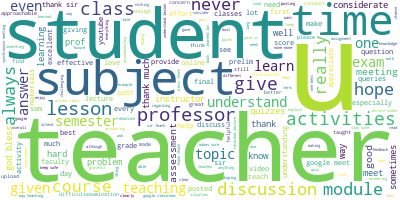

In [14]:
#word cloud
from wordcloud import WordCloud
long_string = ','.join(list(df2['cleaned_texts'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl  

In [16]:
# Adds a column which adds the length of each phrases
df2['Length'] = df2['cleaned_texts'].apply(len)
df2

cleaned_texts  Length
421                       academic knowledge excellent      29
337   accommodating attends concern make sure well ...      53
493                            accommodating professor      24
655   accomodating considerate gained lot knowledge...      96
739   accomodating responsive students queries exce...      69
..                                                 ...     ...
248                             wish synchronous meets      23
474    withdrawed class beginning semester please mind      48
850                   words express grateful professor      33
475   would better teacher first discuss lessons gi...      61
221   would often post assignments midnight underst...     307

[829 rows x 2 columns]

cleaned_texts  Length
421                       academic knowledge excellent      29
337   accommodating attends concern make sure well ...      53
493                            accommodating professor      24
655   accomodating considerate gained lot knowledge...      96
739   accomodating responsive students queries exce...      69
..                                                 ...     ...
248                             wish synchronous meets      23
474    withdrawed class beginning semester please mind      48
850                   words express grateful professor      33
475   would better teacher first discuss lessons gi...      61
221   would often post assignments midnight underst...     307

[829 rows x 2 columns]

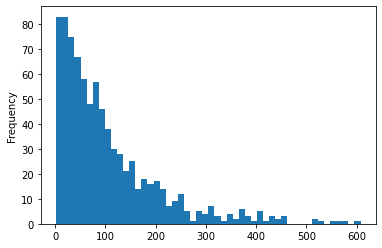

In [17]:
# Plots the frquency of Phrases
df2['Length'].plot(kind = 'hist' , bins = 50)
df2

In [18]:
# Adds a column which adds the length of each phrases
df2['Length'] = df2['cleaned_texts'].apply(len)
df2

cleaned_texts  Length
421                       academic knowledge excellent      29
337   accommodating attends concern make sure well ...      53
493                            accommodating professor      24
655   accomodating considerate gained lot knowledge...      96
739   accomodating responsive students queries exce...      69
..                                                 ...     ...
248                             wish synchronous meets      23
474    withdrawed class beginning semester please mind      48
850                   words express grateful professor      33
475   would better teacher first discuss lessons gi...      61
221   would often post assignments midnight underst...     307

[829 rows x 2 columns]

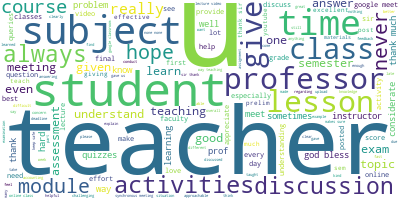

In [19]:
#word cloud
from wordcloud import WordCloud
long_string = ','.join(list(df2['cleaned_texts'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['Cleaned_Text'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['Cleaned_Text']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[df['Cleaned_Text'][0]]])

[' ', 'b', 'e', 'f', 'o', 'r', 'e', ' ', 'u', 'p', 'l', 'o', 'a', 'd', 'i', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'v', 'i', 'd', 'e', 'o', ' ', 'd', 'i', 's', 'c', 'u', 's', 's', 'i', 'o', 'n', ' ', 'i', ' ', 's', 'u', 'g', 'g', 'e', 's', 't', ' ', 't', 'h', 'a', 't', ' ', 's', 'h', 'e', ' ', 'd', 'i', 's', 'c', 'u', 's', 's', ' ', 'i', 't', ' ', 'c', 'l', 'e', 'a', 'r', 'l', 'y', ' ', 'a', 'n', 'd', ' ', 'r', 'e', 'm', 'o', 'v', 'e', ' ', 't', 'h', 'e', ' ', 'e', 'r', 'r', 'o', 'r', 's', ' ', 'b', 'e', 'c', 'a', 'u', 's', 'e', ' ', 'i', 't', ' ', 'c', 'a', 'n', ' ', 'c', 'o', 'n', 'f', 'u', 's', 'e', ' ', 'o', 'u', 'r', ' ', 'c', 'o', 'u', 'r', 's', 'e', ' ', 'c', 'l', 'a', 's', 's', ' ']


In [21]:

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# Form Bigrams
data_words_bigrams = make_bigrams(df['removed_stopwords'])

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download ennlp = spacy.load("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['grade', 'prelim', 'midterm']]


In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1)]]


[[('grade', 1), ('midterm', 1), ('prelim', 1)]]

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"quite" + 0.032*"situation" + 0.032*"continue" + 0.029*"speak" + '
  '0.028*"whole" + 0.024*"soon" + 0.020*"point" + 0.019*"favorite" + '
  '0.019*"move" + 0.017*"knowledgeable"'),
 (1,
  '0.071*"course" + 0.032*"year" + 0.026*"tell" + 0.018*"end" + '
  '0.016*"respond" + 0.015*"last" + 0.014*"receive" + 0.014*"still" + '
  '0.014*"believe" + 0.014*"semester"'),
 (2,
  '0.083*"never" + 0.067*"meet" + 0.044*"class" + 0.033*"synchronous" + '
  '0.029*"upload" + 0.024*"understanding" + 0.022*"time" + 0.021*"video" + '
  '0.020*"need" + 0.020*"week"'),
 (3,
  '0.070*"feel" + 0.057*"safe" + 0.051*"keep" + 0.048*"could" + 0.041*"sir" + '
  '0.039*"future" + 0.030*"accomodate" + 0.027*"overall" + 0.023*"begin" + '
  '0.022*"personal"'),
 (4,
  '0.091*"teacher" + 0.057*"student" + 0.051*"thank" + 0.046*"professor" + '
  '0.045*"subject" + 0.041*"learn" + 0.041*"teach" + 0.034*"always" + '
  '0.029*"much" + 0.028*"class"'),
 (5,
  '0.075*"video" + 0.060*"help" + 0.046*"lecture" + 

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.597928307131001

Coherence Score:  0.4726243081243752


In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.246851 -0.242545       1        1  24.321630
9      0.221455  0.006763       2        1  17.893918
6      0.125236  0.260671       3        1  15.117750
8     -0.004173  0.163195       4        1  12.527475
2      0.114326 -0.003501       5        1  11.166141
5     -0.125544 -0.049660       6        1   5.474118
1     -0.125835  0.000256       7        1   4.701434
0     -0.136206 -0.028911       8        1   3.229792
3     -0.147673 -0.059205       9        1   3.215622
7     -0.168438 -0.047064      10        1   2.352121, topic_info=                  Term        Freq       Total Category  logprob  loglift
27                give  179.000000  179.000000  Default  30.0000  30.0000
64             teacher  249.000000  249.000000  Default  29.0000  29.0000
389              never   91.000000   91.000000  Default  28.0000  28.0000
186               good  106.000000  106.000000  Default  27.0000  27.0000
81               thank  123.000000  123.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
1299         uplifting    1.008936    1.750523  Topic10  -5.4384   3.1988
1286  plssssssssssssss    1.008727    1.750269  Topic10  -5.4386   3.1988
1259              deep    1.008188    1.749891  Topic10  -5.4391   3.1985
430             record   10.431948   20.739044  Topic10  -3.1024   3.0627
428            lecture   19.793136   45.460095  Topic10  -2.4620   2.9184

[428 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
20        1  0.938262  accommodate
370       9  0.887018   accomodate
146       9  0.869751   accountant
3         6  0.916485   accounting
755       5  0.844698       active
...     ...       ...          ...
34        3  0.256140        would
34        7  0.059109        would
448       3  0.943746        wrong
218       7  0.950554         year
69       10  0.925919      youtube

[478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 7, 9, 3, 6, 2, 1, 4, 8])

In [28]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = 'C:\\Programming\\mallet-2.0.8'
mallet_path = 'C:\\Programming\\mallet-2.0.8\\bin\\mallet'

In [29]:

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [30]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('teacher', 0.1334231805929919),
   ('good', 0.1293800539083558),
   ('professor', 0.09703504043126684),
   ('teaching', 0.07008086253369272),
   ('find', 0.03099730458221024),
   ('great', 0.029649595687331536),
   ('knowledge', 0.025606469002695417),
   ('sir', 0.0215633423180593),
   ('face', 0.02021563342318059),
   ('requirement', 0.018867924528301886)]),
 (1,
  [('lesson', 0.14285714285714285),
   ('teach', 0.1364221364221364),
   ('video', 0.09137709137709138),
   ('topic', 0.08622908622908623),
   ('discuss', 0.07979407979407979),
   ('provide', 0.05405405405405406),
   ('conduct', 0.03088803088803089),
   ('helpful', 0.02445302445302445),
   ('easy', 0.023166023166023165),
   ('youtube', 0.019305019305019305)]),
 (2,
  [('class', 0.20933333333333334),
   ('meet', 0.096),
   ('semester', 0.07066666666666667),
   ('grade', 0.048),
   ('query', 0.048),
   ('safe', 0.04133333333333333),
   ('module', 0.04),
   ('stay', 0.02266666666666667),
   ('facilitate', 0.018666666666

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

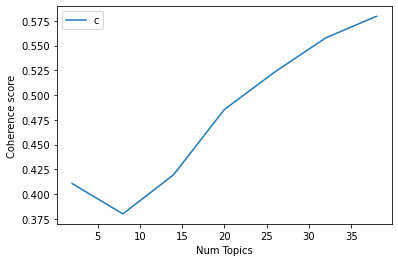

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4106
Num Topics = 8  has Coherence Value of 0.38
Num Topics = 14  has Coherence Value of 0.4196
Num Topics = 20  has Coherence Value of 0.4855
Num Topics = 26  has Coherence Value of 0.5236
Num Topics = 32  has Coherence Value of 0.5579
Num Topics = 38  has Coherence Value of 0.5797


In [35]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.095*"grade" + 0.071*"score" + 0.061*"examination" + 0.050*"show" + '
  '0.047*"week" + 0.037*"feedback" + 0.037*"improve" + 0.034*"midterm" + '
  '0.032*"reply" + 0.032*"prelim"'),
 (1,
  '0.268*"teach" + 0.077*"hope" + 0.065*"safe" + 0.052*"excellent" + '
  '0.042*"stay" + 0.040*"great" + 0.037*"thing" + 0.030*"future" + '
  '0.030*"grateful" + 0.022*"sir"'),
 (2,
  '0.499*"student" + 0.060*"motivate" + 0.044*"encourage" + '
  '0.036*"accommodate" + 0.033*"kind" + 0.025*"watch" + 0.019*"provide" + '
  '0.019*"approach" + 0.019*"fact" + 0.016*"concerned"'),
 (3,
  '0.274*"class" + 0.158*"professor" + 0.052*"feel" + 0.043*"face" + '
  '0.041*"enjoy" + 0.033*"understandable" + 0.024*"care" + 0.024*"pandemic" + '
  '0.022*"fail" + 0.016*"requirement"'),
 (4,
  '0.234*"understand" + 0.170*"topic" + 0.115*"discuss" + 0.038*"easy" + '
  '0.036*"term" + 0.020*"properly" + 0.018*"patience" + 0.018*"solution" + '
  '0.018*"talk" + 0.013*"concept"'),
 (5,
  '0.192*"module" + 0.091*"hop

In [36]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['removed_stopwords']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['removed_stopwords'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
df_dominant_topic.to_csv("hatdog.csv")

In [37]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.1667   
1        1.0              0.1600   
2        2.0              0.1296   
3        3.0              0.1476   
4        4.0              0.1661   

                                            Keywords  \
0  grade, score, examination, show, week, feedbac...   
1  teach, hope, safe, excellent, stay, great, thi...   
2  student, motivate, encourage, accommodate, kin...   
3  class, professor, feel, face, enjoy, understan...   
4  understand, topic, discuss, easy, term, proper...   

                                                Text  
0  [practical, understanding, strict, time, pande...  
1  [teacher, one, favorite, accounting, instructo...  
2  [teacher, accomodating, motivating, understand...  
3  [aside, videos, please, upload, module, lessen...  
4                            [excellent, instructor]

In [38]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

Dominant_Topic                                     Topic_Keywords  \
0.0             0.0  grade, score, examination, show, week, feedbac...   
1.0             0.0  grade, score, examination, show, week, feedbac...   
2.0             7.0  answer, question, problem, explain, happen, so...   
3.0             0.0  grade, score, examination, show, week, feedbac...   
4.0            14.0  make, effort, faculty, concern, accounting, im...   

     Num_Documents  Perc_Documents  
0.0          142.0          0.1665  
1.0           70.0          0.0821  
2.0           34.0          0.0399  
3.0           30.0          0.0352  
4.0           45.0          0.0528

In [39]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"